# Toxic Comment Classification - Part 2 - Training Machine Learning models

In [ ]:
# Installing dependencies
!pip install contractions

     |████████████████████████████████| 284 kB 5.0 MB/s 
     |████████████████████████████████| 106 kB 64.2 MB/s 


In [ ]:
# Importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
import re
import contractions
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from gensim.models import KeyedVectors
import pickle
import random
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, log_loss, accuracy_score, roc_curve, auc, confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Loading the vectorized data-set

In [ ]:
vectorized_df = pd.read_csv('path/to/final_vectorized_df_v2.csv')
vectorized_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300
0,-0.027819,-0.025097,0.016586,-0.020104,0.022592,-0.059228,0.004150,-0.012914,0.049142,-0.315882,-0.032242,0.019668,0.035890,-0.000023,0.048807,0.039577,-0.039247,0.043532,0.005504,-0.001936,-0.003266,0.059542,-0.001479,0.056500,-0.076261,-0.023908,-0.004028,0.063701,0.009539,-0.017370,-0.002115,-0.022223,-0.013678,0.064751,-0.202191,-0.036013,-0.025197,-0.011190,0.031519,0.073918,...,-0.000913,0.012888,-0.023898,-0.057215,-0.007245,-0.033332,0.076273,0.000099,0.008285,0.009558,-0.028828,0.040130,-0.100203,-0.014418,0.018199,-0.467498,-0.029749,0.128018,0.038582,-0.023534,0.001510,-0.086481,0.106400,-0.034978,0.019755,-0.026454,0.005563,-0.046813,0.031830,-0.008078,-0.074876,-0.034577,0.039661,0.044486,0.028640,0.014762,-0.043275,0.022245,0.079330,0.0
1,0.003658,0.030292,0.044201,0.015616,-0.025994,-0.022089,-0.027877,0.005170,0.080933,-0.379206,0.041585,0.044960,0.042747,0.002481,0.010122,-0.021659,0.011691,-0.014208,-0.010809,-0.067935,-0.015015,0.012737,-0.035356,0.016193,-0.018556,-0.014138,0.012336,0.029981,-0.040247,0.017729,0.022977,0.020243,-0.083737,0.055487,-0.291569,0.059373,0.026724,-0.001679,-0.046711,0.053502,...,0.006003,0.070820,-0.001347,-0.040245,-0.048723,0.009665,-0.062070,0.012574,-0.000425,0.025678,0.003306,-0.025589,-0.056002,0.034948,0.056377,-0.357103,-0.038377,0.098845,0.025903,-0.027757,0.008010,-0.015638,0.039098,0.059213,0.016151,-0.038535,0.004773,-0.011630,0.020077,0.001003,0.043182,-0.090644,-0.021626,0.044607,0.094748,0.021490,-0.008086,0.013397,-0.007012,0.0
2,-0.068402,-0.014055,0.004116,0.011997,0.006012,0.030367,-0.042237,-0.005672,0.054542,-0.414327,0.025655,0.001717,0.035715,0.021850,-0.023369,-0.028614,-0.005591,-0.033176,0.011961,0.013021,0.031249,0.132241,0.048353,0.031545,-0.056772,-0.049214,0.032867,0.012334,0.056128,0.028812,-0.062775,0.008095,-0.055607,0.019384,-0.229250,0.019337,-0.017867,-0.039173,-0.016380,-0.027603,...,-0.028762,-0.051410,0.013378,-0.002802,0.035154,-0.019316,0.006006,-0.007902,0.022511,-0.023300,0.002603,0.045759,0.008722,0.012988,0.040783,-0.483662,0.033180,0.148181,-0.032825,0.002921,-0.009938,0.018321,0.010478,0.065902,0.004569,0.031532,0.022979,-0.058781,-0.016875,0.032227,-0.035251,-0.022598,-0.012837,0.006447,-0.065600,-0.011346,-0.001462,-0.000895,0.036339,0.0
3,-0.052891,0.010332,-0.014360,-0.011176,-0.018650,0.006462,-0.017454,0.023015,0.003779,-0.452816,0.000996,0.041322,0.018896,0.039775,0.034204,-0.037212,-0.017184,0.004700,0.015089,-0.030674,0.001059,0.079252,0.013953,0.083211,-0.092904,0.012636,-0.012668,-0.010227,0.045538,-0.005429,0.009401,0.063544,-0.045084,0.009238,-0.256926,0.023886,0.010064,-0.019818,-0.039677,0.001845,...,-0.020084,-0.006162,-0.011139,-0.006311,-0.041134,-0.010668,0.005841,0.041330,0.001612,0.024574,-0.010231,0.045724,0.006784,0.008487,0.039887,-0.499015,0.023221,0.168110,0.019414,-0.021710,-0.007251,0.010424,0.021192,0.010794,0.012619,0.005633,-0.021994,-0.024732,0.010253,0.005150,-0.029167,-0.004759,-0.001911,0.021013,-0.006749,-0.064636,-0.064399,0.015458,0.003308,0.0
4,-0.012218,-0.013789,0.061857,-0.095299,0.048979,0.030729,-0.032299,-0.050947,-0.023149,-0.177742,0.047710,-0.023988,0.009552,-0.047121,-0.046292,0.044694,0.051264,-0.043966,0.040018,0.022214,0.014215,0.098730,0.090521,0.024059,-0.018332,-0.041072,0.024898,-0.012229,0.121005,-0.082351,-0.033105,-0.013403,-0.017137,-0.040260,-0.288929,-0.041369,-0.001611,0.019375,0.016246,-0.016887,...,-0.005525,0.084830,0.020832,-0.042022,0.005766,-0.011492,-0.049951,0.088124,0.022905,0.017484,-0.050194,0.100586,-0.050566,-0.073111,0.054939,-0.345945,-0.075533,0.135311,0.007280,-0.012892,-0.003919,0.060826,-0.039328,0.043097,0.016395,-0.025886,0.006912,-0.052462,0.012577,0.024402,0.014770,-0.005245,-0

In [ ]:
y = vectorized_df.iloc[:, -1].values
X = vectorized_df.iloc[:, :-1].values
X.shape

(302917, 300)

## Splitting the data into train and test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24, stratify=y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(242333, 300)
(60584, 300)
(242333,)
(60584,)


## Principal Component Analysis

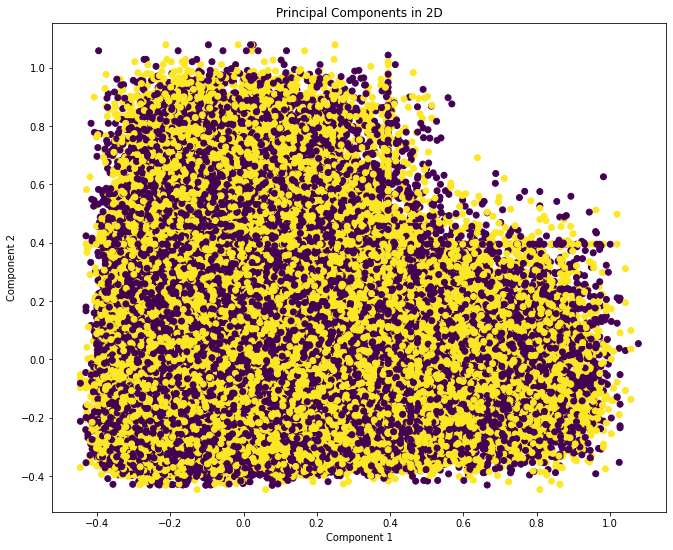

In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
components = pca.fit_transform(X_train)
components = components.reshape(2, -1)

c1 = components[0]
c2 = components[1]

plt.figure(figsize=(11, 9))
plt.scatter(c1, c2, c=y_train)
plt.title("Principal Components in 2D")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

## Training 

In [ ]:
# Defining some utility functions

def plot_auc_roc(y_train, y_pred_train, y_test, y_pred_test):
  plt.figure(figsize=(11, 9))
  fpr_tr, tpr_tr, ths_tr = roc_curve(y_train, y_pred_train)
  auc_tr = auc(fpr_tr, tpr_tr)
  #fpr_cv, tpr_cv, ths_cv = roc_curve(y_cv, y_cv_pred)
  #auc_cv = auc(fpr_cv, tpr_cv)
  fpr_te, tpr_te, ths_te = roc_curve(y_test, y_pred_test)
  auc_te = auc(fpr_te, tpr_te)
  plt.plot(fpr_tr, tpr_tr, color='red', label='Train ROC curve (area = %0.4f)' % auc_tr)
  #plt.plot(fpr_tr, tpr_tr, color='orange', label='ROC curve (area = %0.2f)' % au c_cv)
  plt.plot(fpr_te, tpr_te, color='navy',label='Test ROC curve (area = %0.4f)' % auc_te)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic Curve')
  plt.legend()
  plt.show()


def plot_confusion_matrix(test_y, predict_y):
  C = confusion_matrix(test_y, predict_y)
  A =(((C.T)/(C.sum(axis=1))).T)
  B =(C/C.sum(axis=0))
  plt.figure(figsize=(20,4))
  labels = [0,1]
  # representing A in heatmap format
  cmap=sns.light_palette("blue")
  plt.subplot(1, 3, 1)
  sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.title("Confusion matrix")

  plt.subplot(1, 3, 2)
  sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.title("Precision matrix")
  
  plt.subplot(1, 3, 3)
  # representing B in heatmap format
  sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.title("Recall matrix")
  plt.show()


def evaluate_performance(y_train, y_pred_train, y_test, y_pred_test, model_name=None):
  if model_name is not None:
    print("MODEL NAME:", model_name)
  print("\nTrain Classification Report:\n", classification_report(y_train, y_pred_train))
  print("\nTrain Log Loss:", log_loss(y_train, y_pred_train))
  print("\nTrain Accuracy:", accuracy_score(y_train, y_pred_train))

  print("\nTest Classification Report:\n", classification_report(y_test, y_pred_test))
  print("\nTest Log Loss:", log_loss(y_test, y_pred_test))
  print("\nTest Accuracy:", accuracy_score(y_test, y_pred_test))

  print("\nROC AUC Curve:")
  plot_auc_roc(y_train, y_pred_train, y_test, y_pred_test)

  print('\nTrain confusion_matrix')
  plot_confusion_matrix(y_train, y_pred_train)
  print('\nTest confusion_matrix')
  plot_confusion_matrix(y_test, y_pred_test)

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(class_weight='balanced', random_state=24, n_jobs=-1)
log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=24)

MODEL NAME: Logistic Regression

Train Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.89      0.86    114677
         1.0       0.90      0.84      0.87    127656

    accuracy                           0.87    242333
   macro avg       0.87      0.87      0.87    242333
weighted avg       0.87      0.87      0.87    242333


Train Log Loss: 4.612185654919586

Train Accuracy: 0.8664647406667685

Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.89      0.86     28669
         1.0       0.89      0.84      0.87     31915

    accuracy                           0.87     60584
   macro avg       0.87      0.87      0.87     60584
weighted avg       0.87      0.87      0.87     60584


Test Log Loss: 4.650325593905418

Test Accuracy: 0.8653604912188037

ROC AUC Curve:


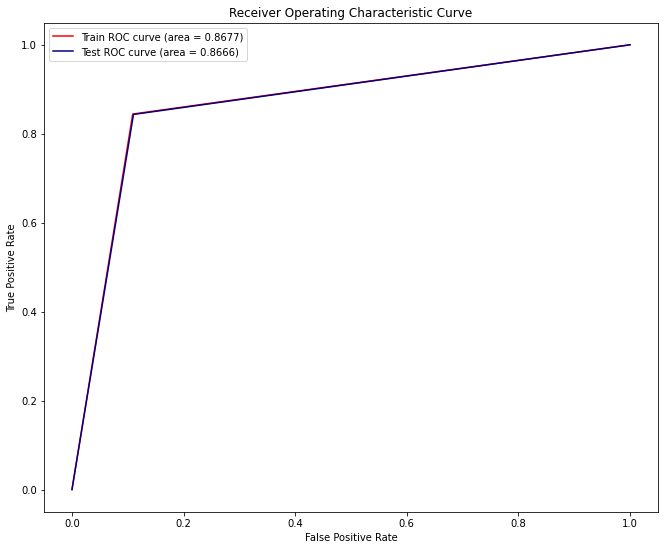


Train confusion_matrix


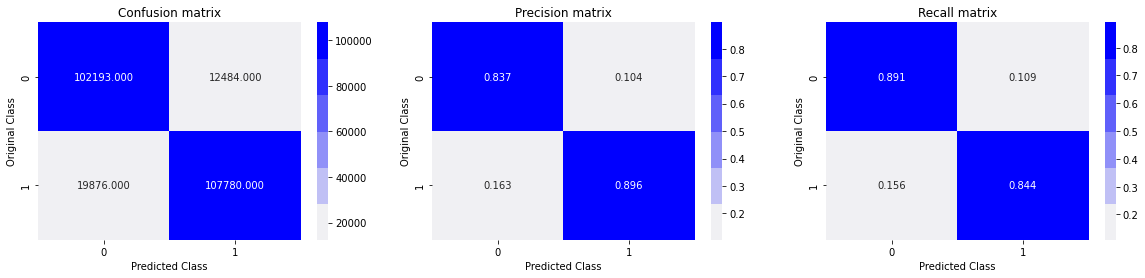


Test confusion_matrix


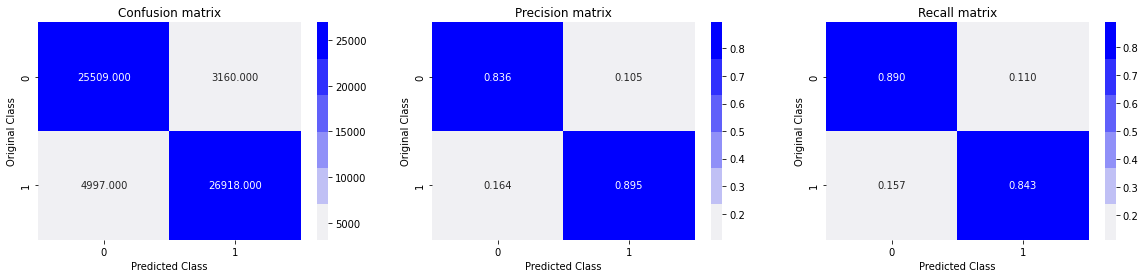

In [ ]:
# Evaluating Results

y_pred_train = log_reg.predict(X_train) 
y_pred_test = log_reg.predict(X_test)

evaluate_performance(y_train, y_pred_train, y_test, y_pred_test, model_name="Logistic Regression")

### Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(random_state=24, class_weight='balanced')
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=24)

MODEL NAME: Decision Tree Classifier

Train Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    114677
         1.0       0.99      1.00      0.99    127656

    accuracy                           0.99    242333
   macro avg       0.99      0.99      0.99    242333
weighted avg       0.99      0.99      0.99    242333


Train Log Loss: 0.23446084564879188

Train Accuracy: 0.9932118200987897

Test Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.92      0.96     28669
         1.0       0.93      1.00      0.96     31915

    accuracy                           0.96     60584
   macro avg       0.96      0.96      0.96     60584
weighted avg       0.96      0.96      0.96     60584


Test Log Loss: 1.3819478312400924

Test Accuracy: 0.9599894361547603

ROC AUC Curve:


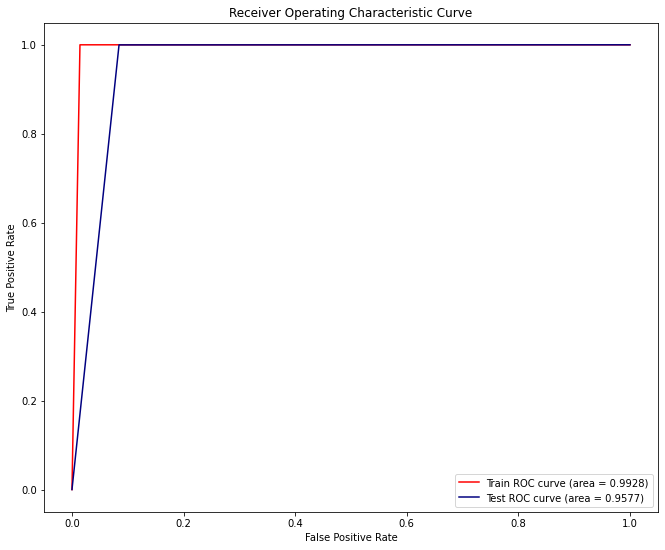


Train confusion_matrix


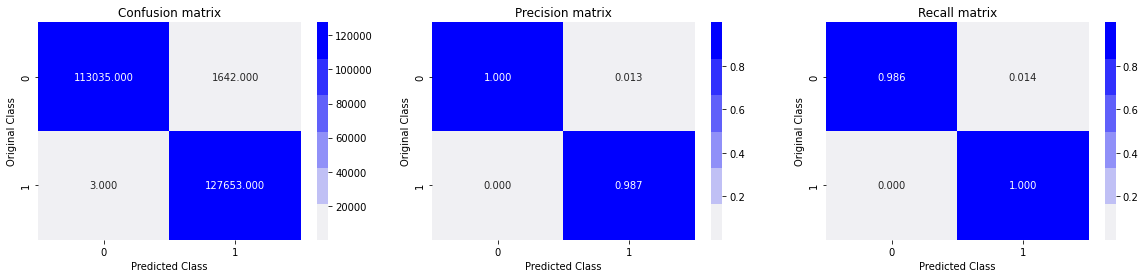


Test confusion_matrix


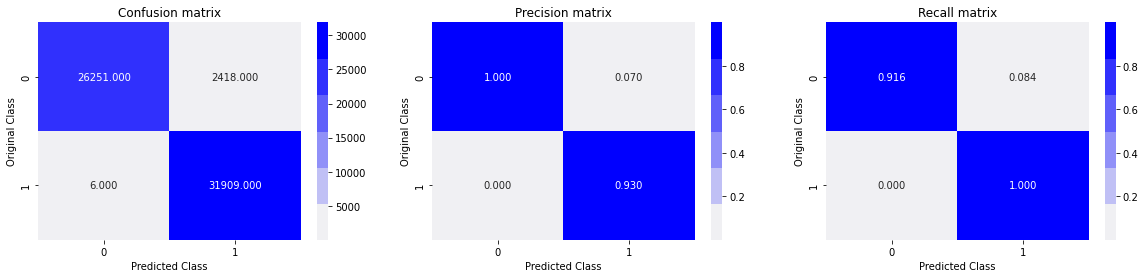

In [ ]:
# Evaluating Results

y_pred_train = dtc.predict(X_train) 
y_pred_test = dtc.predict(X_test)

evaluate_performance(y_train, y_pred_train, y_test, y_pred_test, model_name="Decision Tree Classifier")

### XGBoost Classifier

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_jobs=-1, random_state=24)
xgb.fit(X_train, y_train)

XGBClassifier(n_jobs=-1, random_state=24)

MODEL NAME: XGBoost Classifier

Train Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.85      0.85    114677
         1.0       0.87      0.87      0.87    127656

    accuracy                           0.86    242333
   macro avg       0.86      0.86      0.86    242333
weighted avg       0.86      0.86      0.86    242333


Train Log Loss: 4.837819728573838

Train Accuracy: 0.8599324070597071

Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.85      0.85     28669
         1.0       0.86      0.87      0.86     31915

    accuracy                           0.86     60584
   macro avg       0.86      0.86      0.86     60584
weighted avg       0.86      0.86      0.86     60584


Test Log Loss: 4.930829830791594

Test Accuracy: 0.8572395351908094

ROC AUC Curve:


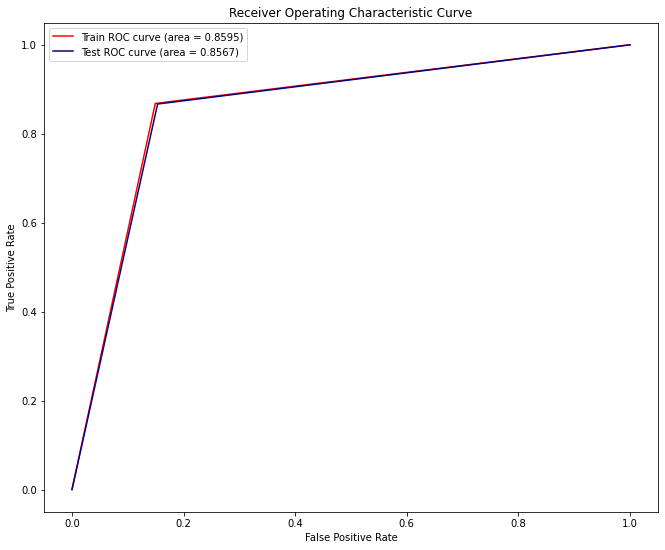


Train confusion_matrix


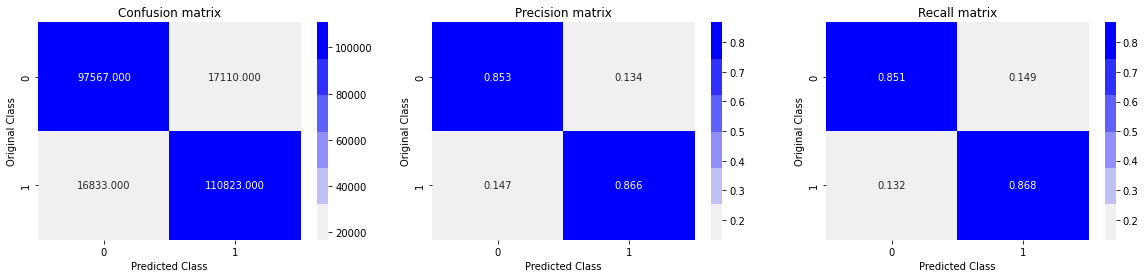


Test confusion_matrix


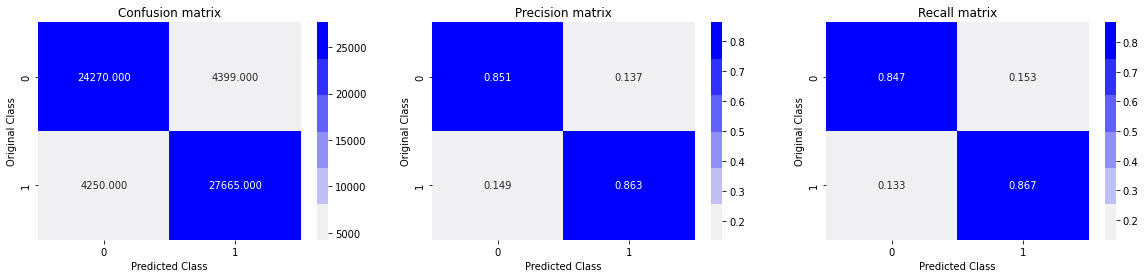

In [ ]:
# Evaluating Results

y_pred_train = xgb.predict(X_train) 
y_pred_test = xgb.predict(X_test)

evaluate_performance(y_train, y_pred_train, y_test, y_pred_test, model_name="XGBoost Classifier")

### Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=100, class_weight='balanced')
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

MODEL NAME: Random Forest Classifier

Train Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    114677
         1.0       0.99      1.00      0.99    127656

    accuracy                           0.99    242333
   macro avg       0.99      0.99      0.99    242333
weighted avg       0.99      0.99      0.99    242333


Train Log Loss: 0.23446084564879188

Train Accuracy: 0.9932118200987897

Test Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     28669
         1.0       0.98      1.00      0.99     31915

    accuracy                           0.99     60584
   macro avg       0.99      0.99      0.99     60584
weighted avg       0.99      0.99      0.99     60584


Test Log Loss: 0.36202006402283843

Test Accuracy: 0.9895186848012677

ROC AUC Curve:


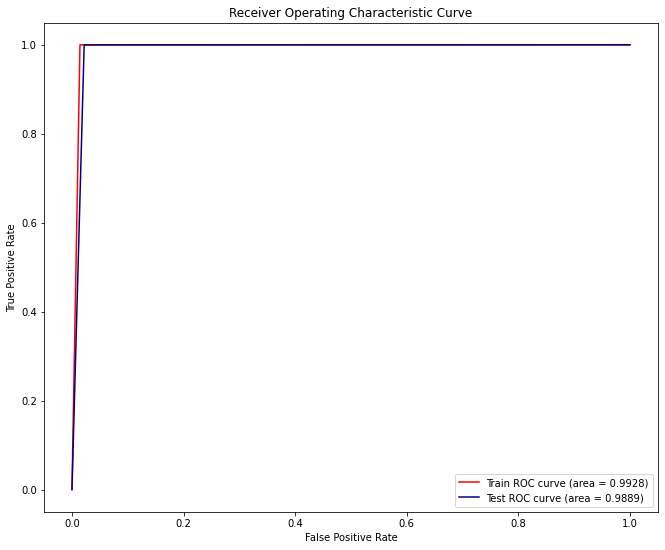


Train confusion_matrix


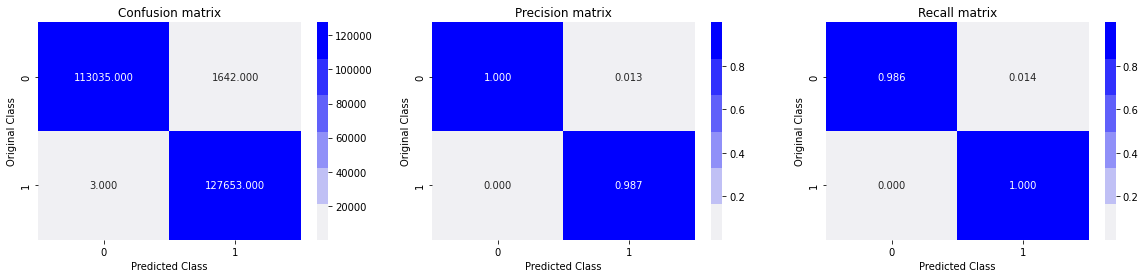


Test confusion_matrix


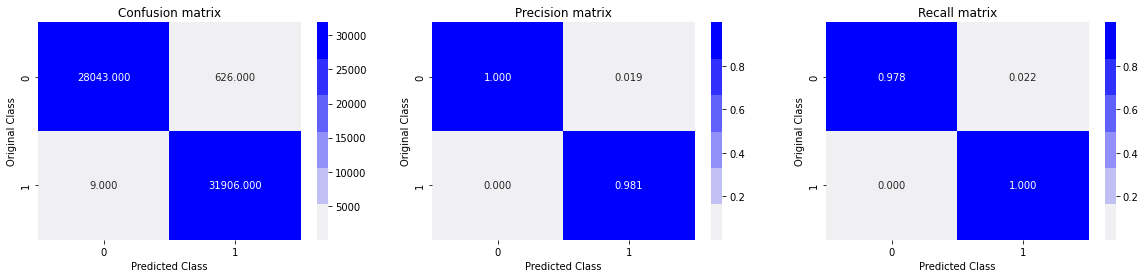

In [ ]:
# Evaluating Results

y_pred_train = rfc.predict(X_train) 
y_pred_test = rfc.predict(X_test)

evaluate_performance(y_train, y_pred_train, y_test, y_pred_test, model_name="Random Forest Classifier")

Best Model: Random Forest Classifier

## Data Pre-processing pipeline for making predictions on new data

In [ ]:
# Text preprocessing functions

def clean(comments):
  # Removing all non-alphabetical characters
  cleaned_comments = []
  for text in comments:
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    text = re.sub(r'^\s+|\s+$', '', text)
    cleaned_comments.append(text)
  return cleaned_comments


def decontract(cleaned_comments):
  decontracted_comments = []
  for comment in cleaned_comments:
    decontracted_words = []
    for word in comment.split():
      decontracted_words.append(contractions.fix(word).lower())
    decontracted_comments.append(re.sub(r'\'', "", " ".join(decontracted_words).strip()))
  return decontracted_comments


def remove_stopwords(decontracted_comments):
  preprocessed_comments = []
  for comment in decontracted_comments:
    comment_words = comment.split()
    filtered_words = [word for word in comment_words if word not in set(stopwords.words('english')) and len(word) > 2]
    preprocessed_comments.append(" ".join(filtered_words).strip())
  return preprocessed_comments


def load_glove_vectors():
  # load the Stanford GloVe model
  # Change this path 
  filename = 'path/to/glove.6B.300d.txt.word2vec'
  glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)
  return glove_model


glove_model = load_glove_vectors()

def vectorize(preprocessed_comments, glove_model=glove_model):
  vectorized_comments = np.empty((len(preprocessed_comments), 300))
  for comment in preprocessed_comments:
    comment_vector = np.zeros(300)
    for word in comment.split():
      try:
        comment_vector = np.add(comment_vector, glove_model[word])
      except:
        pass
    vectorized_comments[list(preprocessed_comments).index(comment)] = comment_vector / (np.sqrt(comment_vector.dot(comment_vector)) + 0.0001)
  return vectorized_comments


def preprocess(comments_data):
  
  # Checks if the input is either a string or a list of strings
  if type(comments_data) == str:
    cleaned_comments = clean([comments_data])
    decontracted_comments = decontract(cleaned_comments)
    preprocessed_comments = remove_stopwords(decontracted_comments)
    vectorized_comments = vectorize(preprocessed_comments)
    return vectorized_comments

  elif type(comments_data) == list and all(isinstance(item, str) for item in comments_data):
    cleaned_comments = clean(comments_data)
    decontracted_comments = decontract(cleaned_comments)
    preprocessed_comments = remove_stopwords(decontracted_comments)
    vectorized_comments = vectorize(preprocessed_comments)
    return vectorized_comments
  
  else:
    raise TypeError("Input must be a string or a list of strings!")

## Sample predictions

In [ ]:
kaggle_test = pd.read_csv("path/to/kaggle_test.csv")
print(kaggle_test.head())
kaggle_test_list = kaggle_test['comment_text'].values.tolist()

                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.


Here, 

PREDICTION: [[0.92 0.08]]

0.92 = Probability that the comment is not toxic (or explicit)

0.08 = Probability that the comment is toxic (or explicit)

In [ ]:
for i in random.sample(range(len(kaggle_test_list)), 20):
  print("COMMENT #", i)
  print("RAW COMMENT TEXT:\n")
  print(kaggle_test_list[i])
  print("\nPREDICTION: ", rfc.predict_proba(preprocess(kaggle_test_list[i]).reshape(1, -1)))
  print("\n ************** ########### ************** ########### ************** ########### ************** \n")

COMMENT # 142191
RAW COMMENT TEXT:

I have closed the VfD in question and am about to unprotect the article page.   Co.,

PREDICTION:  [[0.92 0.08]]

 ************** ########### ************** ########### ************** ########### ************** 

COMMENT # 59264
RAW COMMENT TEXT:

:Hi again:  Thanks for the advice and assessment.  Until wp:warn is updated to allow for improved responses to vandalism sprees, vandalism-only accounts and bad-faith editors, I'll limit my AIV requests to those responding to vandalism edits less than 5 hours after they occur (a reasonable timeliness to respond to such acts, would you agree?), and I'll remember to provide the uw-v warnings on a staged basis as apposed to lumping them together when responding to sprees.  Best:

PREDICTION:  [[0.96 0.04]]

 ************** ########### ************** ########### ************** ########### ************** 

COMMENT # 121886
RAW COMMENT TEXT:

==AfD nomination of Brandt C. Louie== 
 I have nominated Brandt C. Loui